<a href="https://colab.research.google.com/github/wmex91/PhD-Manufacturing-CausalNet-v1/blob/main/causal_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Manufacturing Causal-Net 

The target of the notebook is to learn *causal relations* in a dataset generated from a manufacturing simulator and, secondly, apply some *do-calculus operation* to observe effects of potential intervetions.

The simulator has been built using *Simpy*. Furhter information about Simpy in the following link: https://simpy.readthedocs.io/en/latest/index.html

The tools used are: 
- Pandas for data import and manipulation
- CausalNex for causal learning

In particular, "*CausalNex is a Python library that uses Bayesian Networks to combine machine learning and domain expertise for causal reasoning*". 

The relative documentation is available here: https://causalnex.readthedocs.io/en/latest/index.html

## Preparing the workspace
### Installing the necessary tools
Pandas is by default integrated in the Google Colab environment. 
CausalNex, instead, is not, so is necessary to install it with the following command.



In [ ]:
# Installing causalnex
!pip install causalnex

## Importing Google Drive 
After the installation, drive library is imported in order to easily access to the Google Drive folder where the data has been exported from the previous simulation.

### Importing necessary libraries
After the Google Drive import, all the other necessary lirbaries are imported. The necessary libraries are: 
- os, time, datetime: for file handling operations 
- pandas: for data import, cleaning and input for CausalNex 
- causalnex.structure.notears: for network generation from pandas data
- networkx: for resulting network plotting

In [ ]:
# Importing GDrive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Importing libraries
import os
import time
import datetime
import networkx
import pandas
from causalnex.structure.notears import from_pandas

## Preparing the data set
The dataset generated from the simulation is exported as within a folder. 

The folder name is "yyyy.mm.dd-hh.mm-log", reporting the moment in time where the simulation started. The folder is placed inside of the Google Colab project folder.

The file containing the data is called "merged_logs.csv". It is imported as a Pandas Dataframe with the method "read_csv".

After the import, the head of the dataset and other dataset features are displayed.

In [74]:
# Preparing the data set
# Setting the csv path 
CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/My Notebooks/PhD Notebooks/'\
'Colab-Manufacturing-Model-Learning/Causal-Manufacturing-Learning-v1/dataset/' \
'2022.02.24-11.57-log/merged_logs.csv'

# Getting the dataframe from the file
data = pandas.read_csv(CSV_PATH, delimiter=',')

# Displaying the head and other dataset characteristics
print(data.head(10))
print('\n')
print(data.dtypes)
print('\n')
print(data.columns)

   step  input Machine A  ...  repair time Machine C  Machine C flag
0   0.0              200  ...                      0               0
1   0.1              200  ...                      0               0
2   1.0              200  ...                      0               0
3   1.1              200  ...                      0               0
4   1.5              199  ...                      0               0
5   1.6              199  ...                      0               0
6   2.0              199  ...                      0               0
7   2.1              199  ...                      0               0
8   3.0              199  ...                      0               0
9   3.1              199  ...                      0               0

[10 rows x 25 columns]


step                      float64
input Machine A             int64
time process Machine A      int64
output Machine A            int64
produced Machine A          int64
failure Machine A           int64
MTTF Machin

## Data cleaning and preparation
Since the dataset is virtually generated, NaN or missing value are not present.

Btw, some data preparation is computed. 

### Splitting the step column
The step column has the form of "step.moment": this is not really the meaning of the step used by Simpy. Is instead a "trick" to make logs and debugging easier in the previous phase.

So, for this phase, is more coherent to split this column into two different columns, namely "step" and "moment".


The split is performed in 3 steps: 
1. The "step" column is converted in type, from float to string. The result is saved in a new columns called "step_str" attached on the right to the initial dataframe. 
2. Using the str.split method, the "step_str" column is split into 2 columns at the "." (*point*). The resulting columns are saved into 2 columns called "step" and "moment". 
3. The no more necessary temporary column "step_str" is dropped.

Finally, the columns are reordered keeping the new "step" and "moment" columns on the left of the dataset and converting them into int type. 

In [75]:
# Splitting the "step" column into "step" and "moment" in 3 steps:
# 1. Converting the step col into string type
data["step_str"] = data["step"].astype(str)
# 2. Using str.split to split the col at the "."
data[["step", "moment"]] = data.step_str.str.split(".", expand = True)
# 3. Dropping the temp col
data.drop(columns=["step_str"], inplace=True)

# Reordering the result
data = data[["step", "moment", "failure Machine A", "Machine A flag", 
      "failure Machine B",  "Machine B flag", "failure Machine C", 
      "Machine C flag"]]

# Converting everything in int 
data = data.astype(int)

print(data)

            step  moment  ...  failure Machine C  Machine C flag
0              0       0  ...                  0               0
1              0       1  ...                  0               0
2              1       0  ...                  0               0
3              1       1  ...                  0               0
4              1       5  ...                  0               0
...          ...     ...  ...                ...             ...
1310832  1036795       0  ...                  0               0
1310833  1036796       0  ...                  0               0
1310834  1036797       0  ...                  0               0
1310835  1036798       0  ...                  0               0
1310836  1036799       0  ...                  0               0

[1310837 rows x 8 columns]


## Dropping unnecessary columns for learning 
In the previous step, during the columns reordering, not all the columns of the initial dataset have been used. For that reason, the unused columns have been dropped. 

So, there are only 2 columns left to be dropped: "step" and "moment". 

They are not necessary since the Bayesian Network used are not time-dependent: they just analyse the datast line-to-line trying to understand relations between features, without taking into account the time. 

In the following, "step" and "moment" are dropped.

In [76]:
# Dropping the unneccessary columns
data.drop(columns=["step", "moment"], inplace=True)
print(data)

         failure Machine A  Machine A flag  ...  failure Machine C  Machine C flag
0                        0               0  ...                  0               0
1                        0               0  ...                  0               0
2                        0               0  ...                  0               0
3                        0               0  ...                  0               0
4                        0               0  ...                  0               0
...                    ...             ...  ...                ...             ...
1310832                  0               1  ...                  0               0
1310833                  0               1  ...                  0               0
1310834                  0               1  ...                  0               0
1310835                  0               1  ...                  0               0
1310836                  0               1  ...                  0               0

[13

In [ ]:
# Dropping the unneccessary columns - DEPRECATO COL NUOVO IMPLEMENT
"""
data.drop(columns=["step", "moment", "input Machine A", "time process Machine A", 
                   "output Machine A", "produced_x", "MTTF Machine A", 
                   "repair time Machine A"], inplace=True)

data.drop(columns=["step", "moment", "input Machine B", "time process Machine B", 
                   "output Machine B", "produced_y", "MTTF Machine B", 
                   "repair time Machine B"], inplace=True)

data.drop(columns=["step", "moment", "input Machine C", "time process Machine C", 
                   "output Machine C", "produced", "MTTF Machine C", 
                   "repair time Machine C"], inplace=True)

# Printing the head
print(data)
"""

In [77]:
# Saving the light dataset into csv
LIGHT_CSV_PATH = '/content/drive/MyDrive/Colab Notebooks/My Notebooks/' \
'PhD Notebooks/Colab-Manufacturing-Model-Learning/' \
'Causal-Manufacturing-Learning-v1/dataset/2022.02.24-11.57-log/' \
'light-logs.csv'

data.to_csv(LIGHT_CSV_PATH)

In [78]:
# Getting tabu child nodes
tabu_child_list = [x for x in data.columns if 'failure' in x]

print('Tabu child list: ', tabu_child_list)

# Training the model
# Declaring and mining the structure of the causal-net
start_time = time.time()
structure_model = from_pandas(data, tabu_child_nodes=tabu_child_list)
finish_time = time.time()
sim_time = finish_time - start_time

# Printing the structure model with Python
print("Total training time: {} min, {} secs".format(round(sim_time/60, 0), 
                                                    round(sim_time%60, 0)))
# print("Total training time: {} seconds".format(round(sim_time, 2)/60))
print(structure_model)

Tabu child list:  ['failure Machine A', 'failure Machine B', 'failure Machine C']
Total training time: 1.0 min, 5.0 secs
StructureModel with 6 nodes and 15 edges


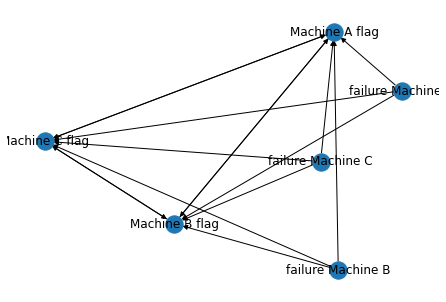

In [79]:
# Printing the structure model with networkx
networkx.draw(structure_model, with_labels=True)

StructureModel with 6 nodes and 6 edges


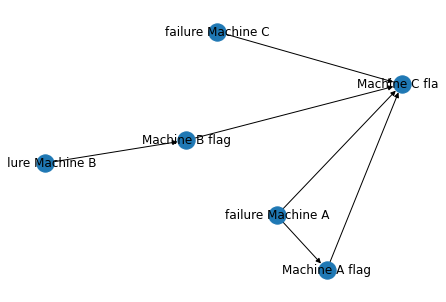

In [80]:
structure_model.remove_edges_below_threshold(0.1)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)

StructureModel with 6 nodes and 6 edges


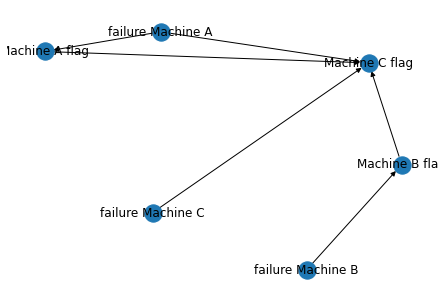

In [81]:
structure_model.remove_edges_below_threshold(0.2)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)

StructureModel with 6 nodes and 5 edges


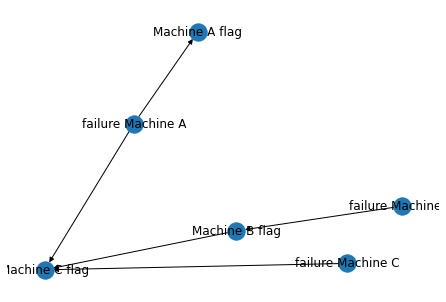

In [82]:
structure_model.remove_edges_below_threshold(0.3)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)

StructureModel with 6 nodes and 3 edges


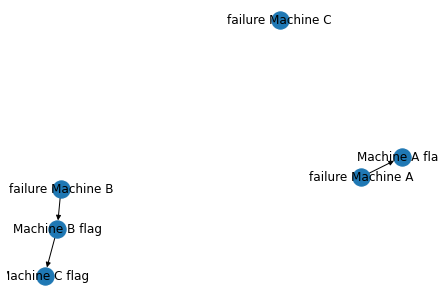

In [83]:
structure_model.remove_edges_below_threshold(0.4)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)

StructureModel with 6 nodes and 3 edges


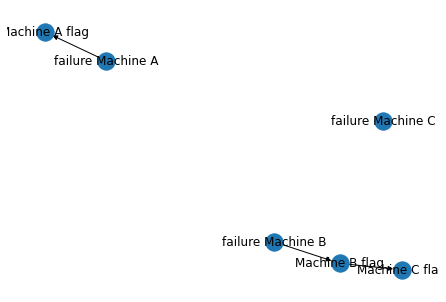

In [84]:
structure_model.remove_edges_below_threshold(0.5)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)

StructureModel with 6 nodes and 3 edges


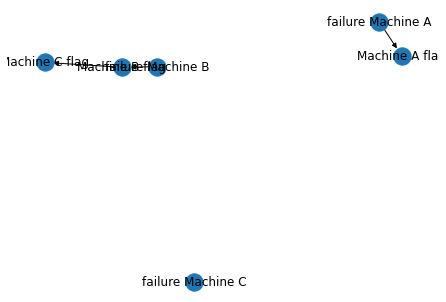

In [85]:
structure_model.remove_edges_below_threshold(0.6)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)

StructureModel with 6 nodes and 2 edges


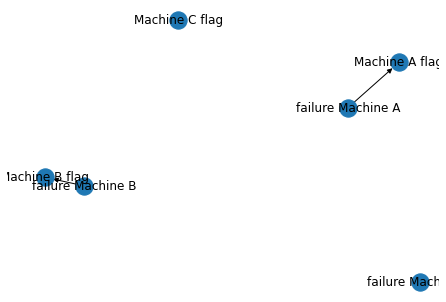

In [86]:
structure_model.remove_edges_below_threshold(0.7)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)

StructureModel with 6 nodes and 2 edges


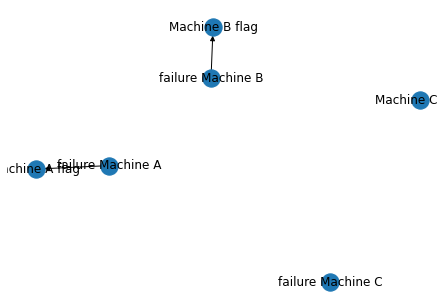

In [87]:
structure_model.remove_edges_below_threshold(0.8)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)

StructureModel with 6 nodes and 2 edges


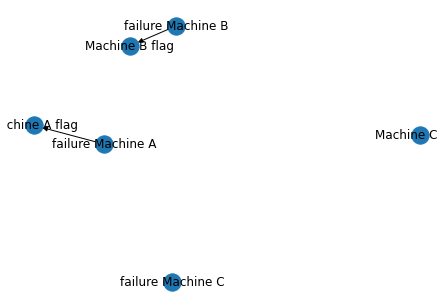

In [88]:
structure_model.remove_edges_below_threshold(0.9)
print(structure_model)
# Printing the structure model again
networkx.draw(structure_model, with_labels=True)

In [ ]:
structure_model.edges(data = 'weight')

OutEdgeDataView([('failure Machine A', 'Machine A flag', 0.9519557567274209), ('failure Machine B', 'Machine B flag', 0.9653947512365773)])